## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
PATH = "data/bulldozers/"

In [4]:
!ls {PATH}

Train.csv


## The data

## (a) reading csv, specify dates

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False,
                     parse_dates=["saledate"])

In [6]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### before processing

In [7]:
try:
    m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    # The following code is supposed to fail due to string values in the input data
    m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)
    assert False
except Exception as e:
    print(f"something went wrong: {e}")

something went wrong: could not convert string to float: 'Low'


This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

## (b) processing dates

In [8]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

## (c) change string object to categorical

In [9]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [10]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [11]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [12]:
# df_raw.UsageBand = df_raw.UsageBand.cat.codes + 1

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [13]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [14]:
!ls -lrth tmp/bulldozers-raw

-rw-r--r--  1 shaojun  110156316    67M Dec 28 19:15 tmp/bulldozers-raw


## (d) change everything to numbers

In the future we can simply read it from this fast format.

In [15]:
import feather
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [16]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [17]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

## Random Forests

## overfit

We now have something we can pass to a random forest!

In [18]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9830337237882019

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [19]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

## Base model

Let's try our model again, this time with separate training and validation sets.

In [20]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def get_scores(m, config=None):
    res = {
        'config':[config],
        'rmse_train': [rmse(m.predict(X_train), y_train)],
        'rmse_dev': [rmse(m.predict(X_valid), y_valid)],
        'r2_train': [m.score(X_train, y_train)],
        'r2_dev': [m.score(X_valid, y_valid)],
        'r2_oob': [None],
        'n_trees':[m.n_estimators],
        'train_size': [len(y_train)],
        'dev_size': [len(y_valid)],
    }
    if hasattr(m, 'oob_score_'): 
        if m.oob_score_ > 0:
            res['r2_oob'][0] = m.oob_score_
    return pd.DataFrame(res)

In [21]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 637 ms, total: 1min 21s
Wall time: 9.76 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
results = get_scores(m, 'baseline-slow')
results

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,0.090836,0.250835,0.982755,0.887636,None,10,389125,12000


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), even thought we care overfitting badly by looking at the validation set score.

## Speeding things up

In [23]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [24]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [25]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [26]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: user 3.03 s, sys: 34 ms, total: 3.07 s
Wall time: 373 ms


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [27]:
tmp = get_scores(m, 'speedup')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,speedup,0.111354,0.360487,0.973082,0.767926,None,10,20000,12000


In [28]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,0.090836,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,0.111354,0.360487,0.973082,0.767926,None,10,20000,12000


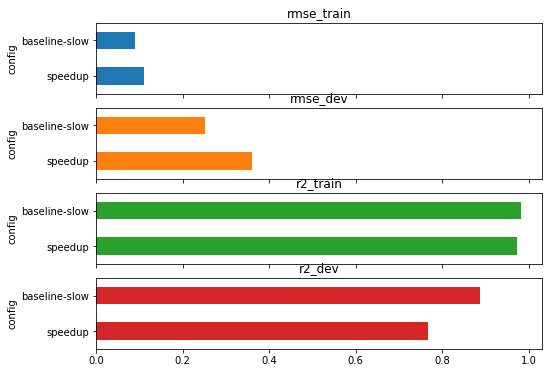

In [29]:
cols = results.columns[:5]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=0,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

## Single tree

In [30]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [31]:
tmp = get_scores(m, 'single tree')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,single tree,0.523713,0.58076,0.404598,0.397661,None,1,20000,12000


In [32]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,0.090836,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,0.111354,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,0.523713,0.580760,0.404598,0.397661,None,1,20000,12000


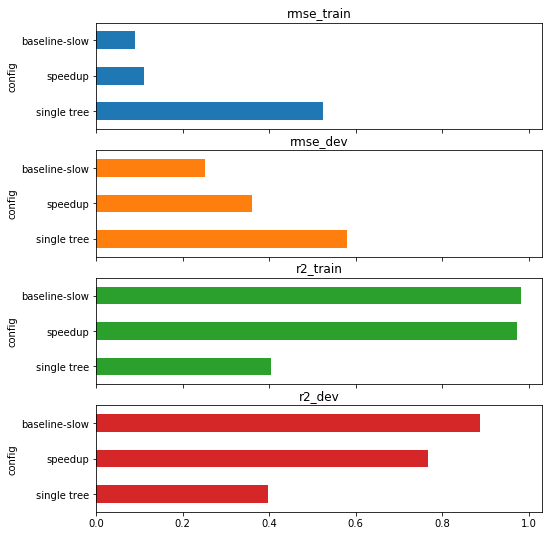

In [33]:
cols = results.columns[:5]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=0,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

Let's see what happens if we create a bigger tree.

In [34]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [35]:
tmp = get_scores(m, 'single deep tree')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,single deep tree,4.351168e-17,0.505234,1.0,0.544138,None,1,20000,12000


In [36]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000


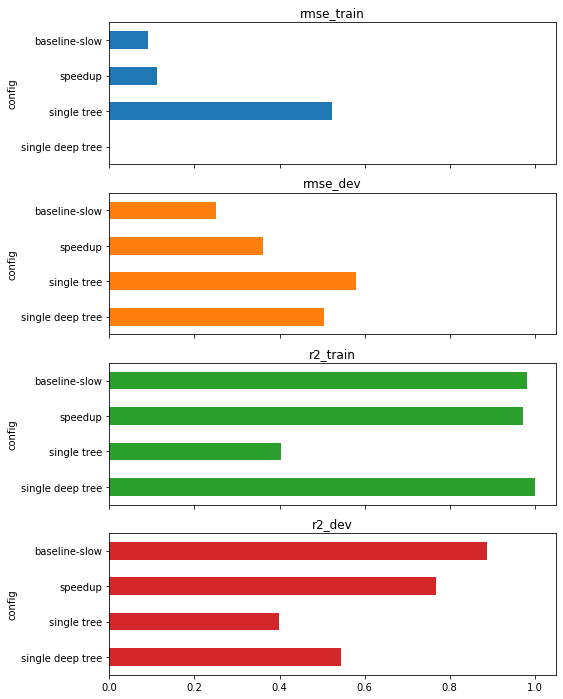

In [37]:
cols = results.columns[:5]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=0,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [38]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [39]:
tmp = get_scores(m, 'baseline-fast')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-fast,0.110845,0.356813,0.973328,0.772632,None,10,20000,12000


In [40]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000


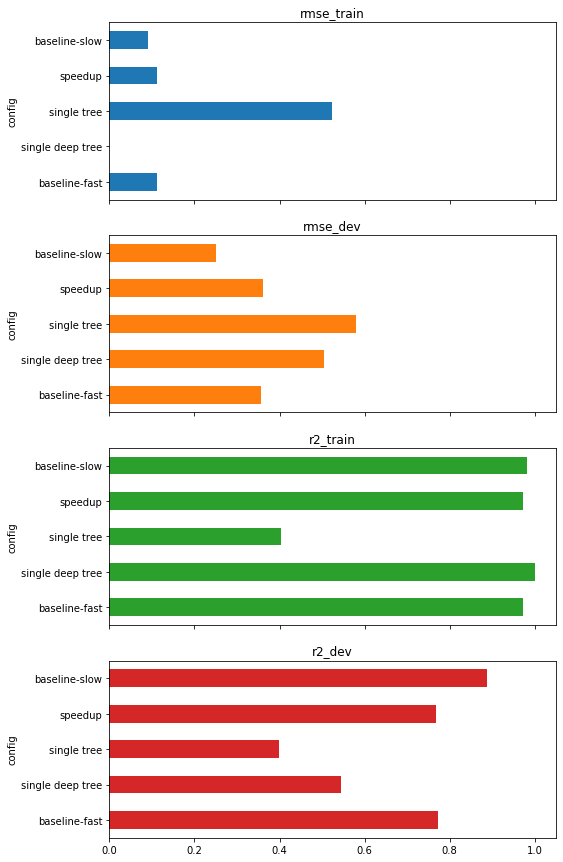

In [41]:
cols = results.columns[:5]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=0,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

We'll grab the predictions for each individual tree, and look at one example.

In [42]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.30565, 9.21034, 9.10498, 9.3501 , 9.21034, 9.21034, 9.04782, 9.10498, 9.82553, 9.25913]),
 9.262921168438755,
 9.104979856318357)

In [43]:
preds.shape

(10, 12000)

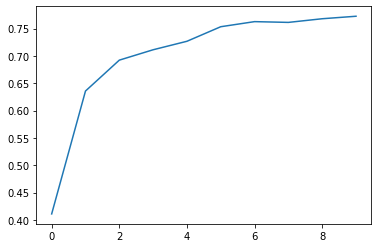

In [44]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [45]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
get_scores(m, "")

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.101298,0.337389,0.977725,0.796713,None,20,20000,12000


In [46]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
get_scores(m, "")

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.096985,0.335088,0.979581,0.799476,None,40,20000,12000


In [47]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
tmp = get_scores(m, "baseline-fast-80")
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-fast-80,0.094509,0.3413,0.98061,0.791973,None,80,20000,12000


In [49]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000
0,baseline-fast-80,9.450899e-02,0.341300,0.980610,0.791973,None,80,20000,12000


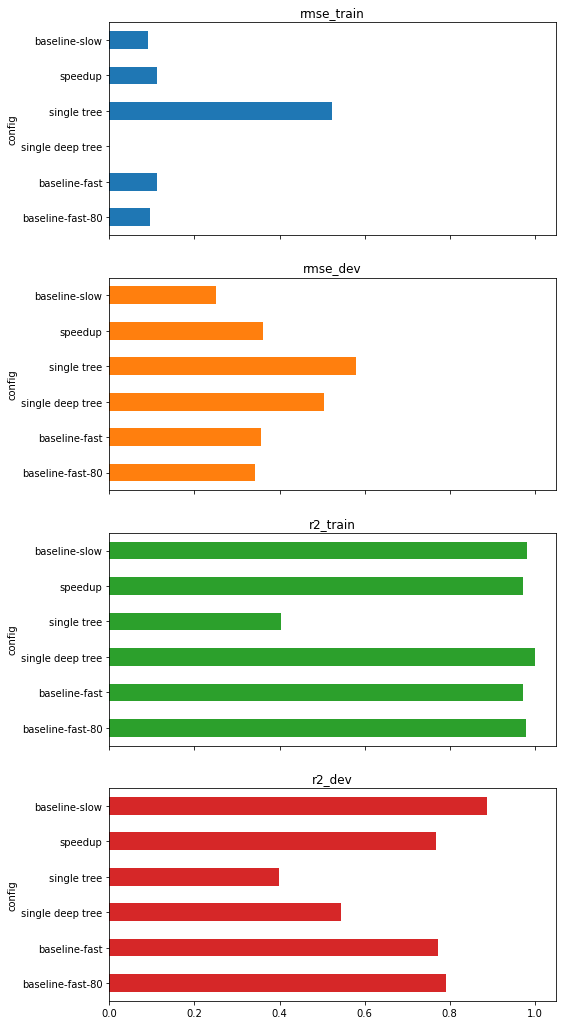

In [50]:
cols = results.columns[:5]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=45,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
tmp = get_scores(m, "baseline-fast-40-oob")
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-fast-40-oob,0.097262,0.340374,0.979464,0.7931,0.853302,40,20000,12000


In [53]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000
0,baseline-fast-80,9.450899e-02,0.341300,0.980610,0.791973,None,80,20000,12000
0,baseline-fast-40-oob,9.726234e-02,0.340374,0.979464,0.793100,0.853302,40,20000,12000


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [54]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [55]:
set_rf_samples(20000)

In [56]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 735 ms, total: 1min 20s
Wall time: 10.3 s


/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
tmp = get_scores(m, "baseline-subsample-10")
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-10,0.090672,0.250642,0.982818,0.887809,None,10,389125,12000


In [58]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000
0,baseline-fast-80,9.450899e-02,0.341300,0.980610,0.791973,None,80,20000,12000
0,baseline-fast-40-oob,9.726234e-02,0.340374,0.979464,0.793100,0.853302,40,20000,12000
0,baseline-subsample-10,9.067175e-02,0.250642,0.982818,0.887809,None,10,389125,12000


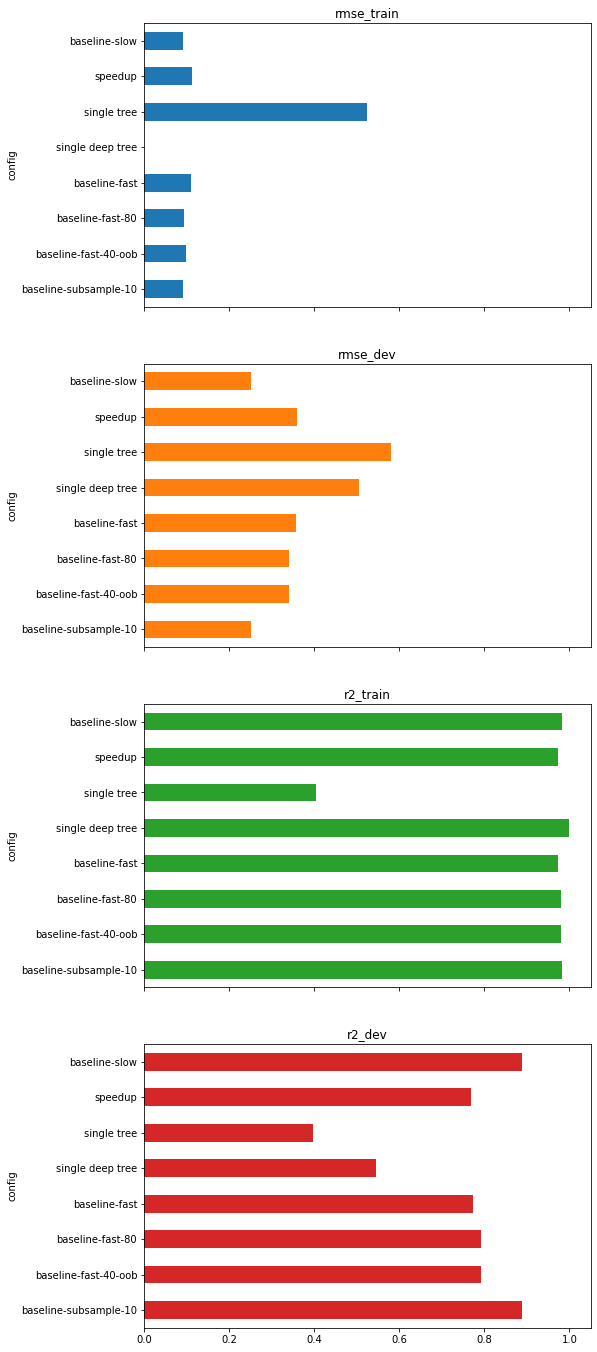

In [59]:
cols = results.columns[:5]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=45,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [60]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [61]:
tmp = get_scores(m, "baseline-subsample-40")
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-40,0.078468,0.237733,0.987132,0.899068,0.90811,40,389125,12000


In [62]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000
0,baseline-fast-80,9.450899e-02,0.341300,0.980610,0.791973,None,80,20000,12000
0,baseline-fast-40-oob,9.726234e-02,0.340374,0.979464,0.793100,0.853302,40,20000,12000
0,baseline-subsample-10,9.067175e-02,0.250642,0.982818,0.887809,None,10,389125,12000
0,baseline-subsample-40,7.846834e-02,0.237733,0.987132,0.899068,0.90811,40,389125,12000


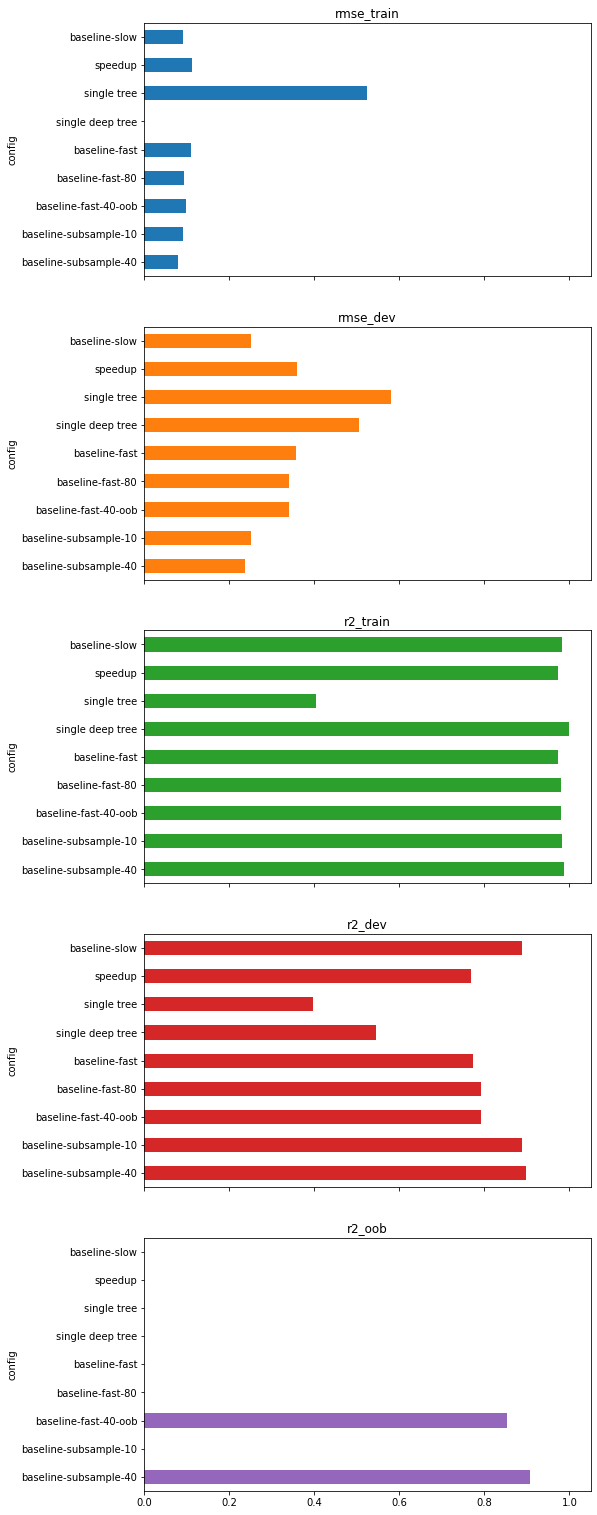

In [63]:
cols = results.columns[:6]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=45,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [64]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [65]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [66]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
tmp = get_scores(m, 'baseline-slow-40')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-40,0.078259,0.236638,0.9872,0.899996,0.908607,40,389125,12000


In [68]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000
0,baseline-fast-80,9.450899e-02,0.341300,0.980610,0.791973,None,80,20000,12000
0,baseline-fast-40-oob,9.726234e-02,0.340374,0.979464,0.793100,0.853302,40,20000,12000
0,baseline-subsample-10,9.067175e-02,0.250642,0.982818,0.887809,None,10,389125,12000
0,baseline-subsample-40,7.846834e-02,0.237733,0.987132,0.899068,0.90811,40,389125,12000
0,baseline-slow-40,7.825889e-02,0.236638,0.987200,0.899996,0.908607,40,389125,12000


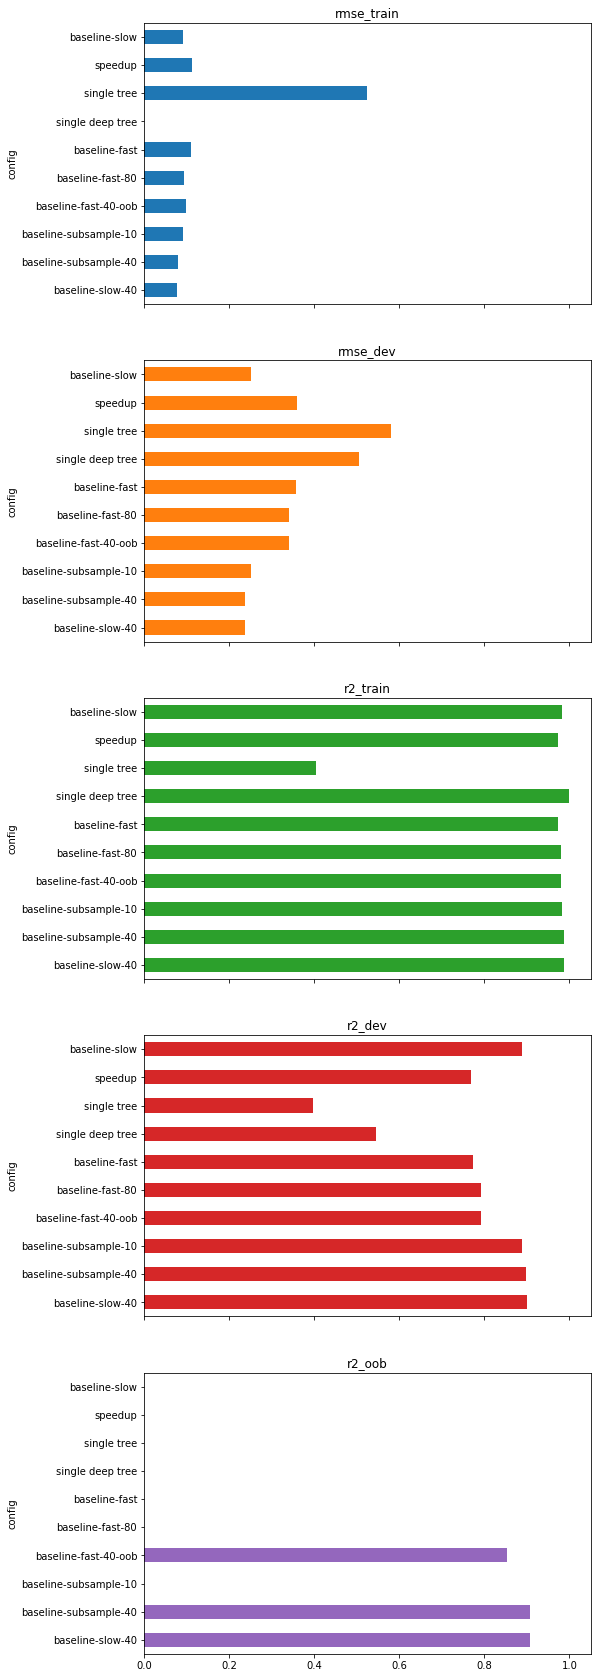

In [69]:
cols = results.columns[:6]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=45,
    ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

In [70]:
t=m.estimators_[0].tree_

In [71]:
dectree_max_depth(t)

48

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [72]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [73]:
tmp = get_scores(m, 'baseline-slow-tuning')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-tuning,0.140757,0.234665,0.958593,0.901657,0.906946,40,389125,12000


In [74]:
t=m.estimators_[0].tree_

In [75]:
dectree_max_depth(t)

35

In [76]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
tmp = get_scores(m, 'baseline-slow-tuning')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-tuning,0.114985,0.235244,0.972367,0.901171,0.908501,40,389125,12000


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [78]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [79]:
tmp = get_scores(m, 'baseline-slow-tuning')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-tuning,0.11908,0.226794,0.970364,0.908143,0.911875,40,389125,12000


In [80]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow,9.083630e-02,0.250835,0.982755,0.887636,None,10,389125,12000
0,speedup,1.113544e-01,0.360487,0.973082,0.767926,None,10,20000,12000
0,single tree,5.237125e-01,0.580760,0.404598,0.397661,None,1,20000,12000
0,single deep tree,4.351168e-17,0.505234,1.000000,0.544138,None,1,20000,12000
0,baseline-fast,1.108445e-01,0.356813,0.973328,0.772632,None,10,20000,12000
0,baseline-fast-80,9.450899e-02,0.341300,0.980610,0.791973,None,80,20000,12000
0,baseline-fast-40-oob,9.726234e-02,0.340374,0.979464,0.793100,0.853302,40,20000,12000
0,baseline-subsample-10,9.067175e-02,0.250642,0.982818,0.887809,None,10,389125,12000
0,baseline-subsample-40,7.846834e-02,0.237733,0.987132,0.899068,0.90811,40,389125,12000
0,baseline-slow-40,7.825889e-02,0.236638,0.987200,0.899996,0.908607,40,389125,12000


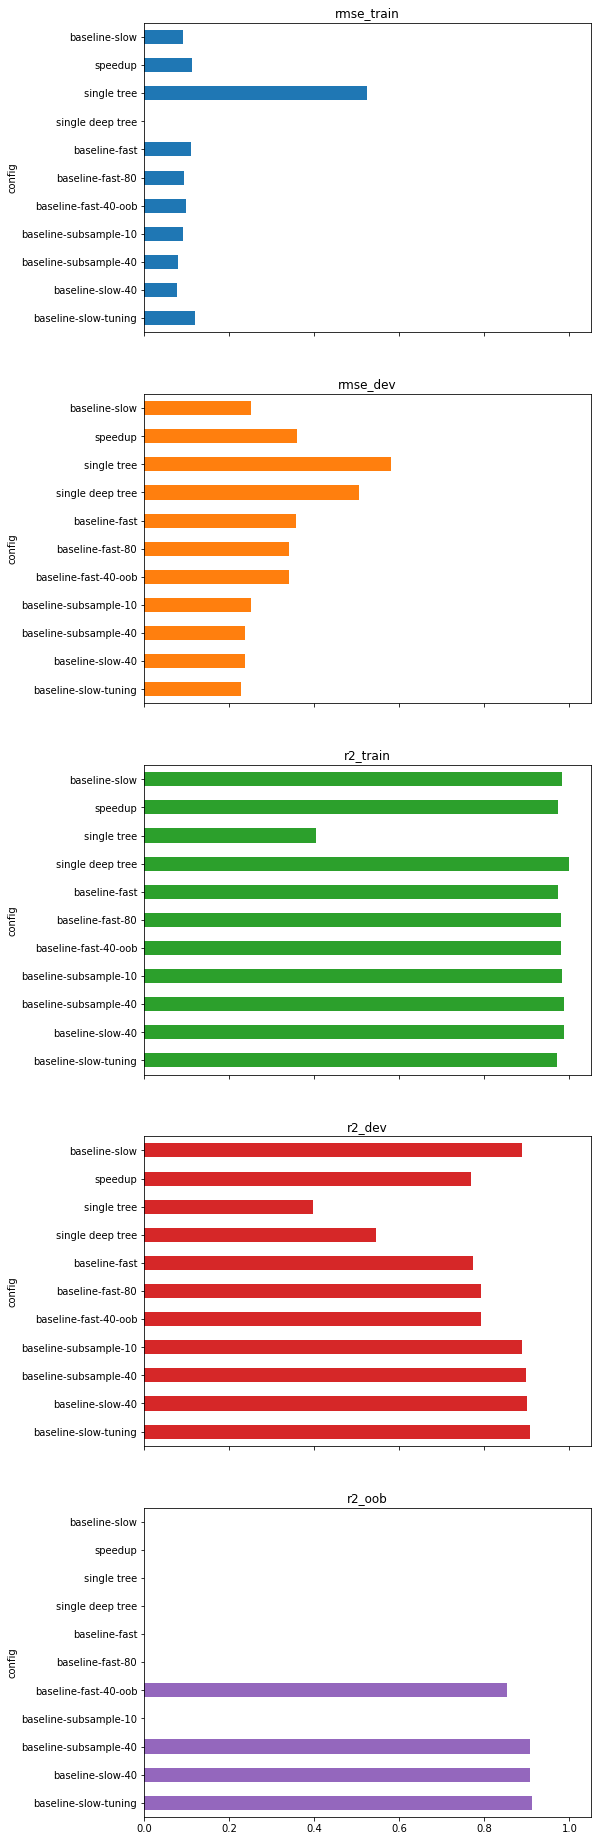

In [81]:
cols = results.columns[:6]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=90,
    # ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);

We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)